<a href="https://colab.research.google.com/github/arazm21/ML-homework_4/blob/main/expression_notebook_first.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# loading the data and organising it

In [5]:
! pip install kaggle
from google.colab import drive
drive.mount('/content/drive')
! mkdir ~/.kaggle
!cp /content/drive/MyDrive/ColabNotebooks/kaggle_API_credentials/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge
! unzip challenges-in-representation-learning-facial-expression-recognition-challenge

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mkdir: cannot create directory ‘/root/.kaggle’: File exists
 78% 223M/285M [00:00<00:00, 543MB/s] 
100% 285M/285M [00:06<00:00, 48.3MB/s]
Archive:  challenges-in-representation-learning-facial-expression-recognition-challenge.zip
  inflating: example_submission.csv  
  inflating: fer2013.tar.gz          
  inflating: icml_face_data.csv      
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: test.csv                
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train.csv               


In [3]:
import torch # Main PyTorch Library
from torch import nn # Used for creating the layers and loss function
from torch.optim import Adam # Adam Optimizer
import torchvision.transforms as transforms # Transform function used to modify and preprocess all the images
from torch.utils.data import Dataset, DataLoader # Dataset class and DataLoader for creating the objects
from sklearn.preprocessing import LabelEncoder # Label Encoder to encode the classes from strings to numbers
import matplotlib.pyplot as plt # Used for visualizing the images and plotting the training progress
from PIL import Image # Used to read the images from the directory
import pandas as pd # Used to read/create dataframes (csv) and process tabular data
import numpy as np # preprocessing and numerical/mathematical operations
import os # Used to read the images path from the directory

device = "cuda" if torch.cuda.is_available() else "cpu" # detect the GPU if any, if not use CPU, change cuda to mps if you have a mac
print("Device available: ", device)

Device available:  cpu


In [13]:
import torch
from torch.utils.data import Dataset, Subset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

class ExpressionDataset(Dataset):
    def __init__(self, csv_file, train=True):
        self.data = pd.read_csv(csv_file)
        self.train = train

        # Parse pixel strings into 48x48 arrays
        self.images = self.data['pixels'].apply(lambda x: np.fromstring(x, sep=' ', dtype=np.uint8).reshape(48, 48))
        self.images = torch.tensor(np.stack(self.images.values), dtype=torch.float32).unsqueeze(1) / 255.0  # [N, 1, 48, 48]

        if self.train:
            self.labels = torch.tensor(self.data['emotion'].values, dtype=torch.long)
        else:
            self.labels = None

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if self.train:
            return self.images[idx], self.labels[idx]
        return self.images[idx]  # test set returns only images

def get_data(slice=5, train=True):
    file_path = "train.csv" if train else "test.csv"
    full_dataset = ExpressionDataset(file_path, train=train)
    sub_dataset = Subset(full_dataset, indices=range(0, len(full_dataset), slice))
    return sub_dataset

def make_loader(dataset, batch_size):
    loader = DataLoader(dataset=dataset,
                        batch_size=batch_size,
                        shuffle=True,
                        pin_memory=True,
                        num_workers=2)
    return loader


## test that loading was ok

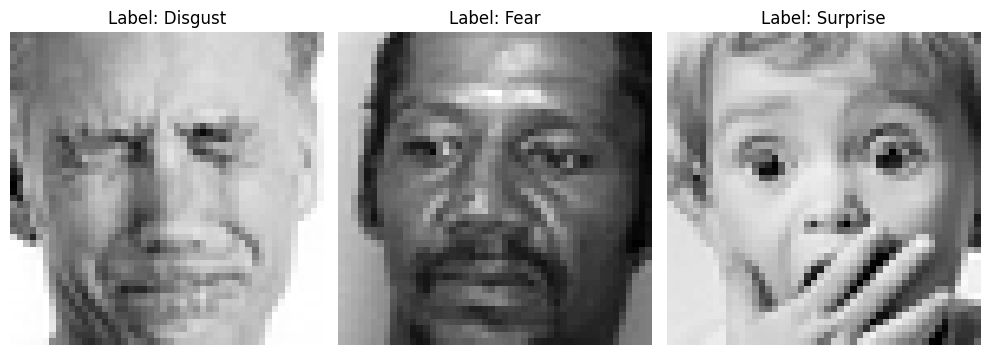

In [14]:
# Load and create loader
dataset = get_data(slice=1, train=True)
loader = make_loader(dataset, batch_size=3)

# Get a batch
images, labels = next(iter(loader))

# Class names from FER2013
emotion_names = [
    "Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"
]

# Plot the first 3 images
plt.figure(figsize=(10, 4))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(images[i][0], cmap='gray')
    plt.title(f"Label: {emotion_names[labels[i].item()]}")
    plt.axis('off')
plt.tight_layout()
plt.show()
